# Finite Markov Chains

Markov chains are one of the most useful classes of stochastic processes, being

* simple, flexible and supported by many elegant theoretical results
* valuable for building intution about random dynamic models
* central to quantitative modeling in their own right

You will find them in many of the workhorse models of economics and finance. 

In [3]:
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

### Stochastic Matrices

A __stochastic matrix (or Markov matrix)__ is an $n \times n$ square matrix $P$ such that

1. each element of $P$ is nonnegative, and
2. each row of $P$ sums to one

Each row of $P$ can be regarded as a probability mass function over $n$ possible outcomes.There is a close connection between stochastic matrices and Markov chains. Let $S$ be a finite set with $n$ elements $\{x_1, \cdots, x_n\}$. The set $S$ is called the __state space__ and $x_1, \cdots, x_n$ are the __state values__. 

A __Markov chain__ $\{X_t\}$ on $S$ is a sequence of random variables on $S$ that have the __Markon proeprty__. This means that, for any date $t$ and any state $y \in S$, 

$$P\{X_{t+1} = y | X_t \} = P\{X_{t+1} = y | X_t, X_{t-1}, \cdots \}$$

In other words, knowing the current state is enough to know probabilities for future states.In particular, the dynamics of a Markov chain are fully determined by the set of values:

$$P(x, y) := P\{X_{t+1} = y | X_t = x \} \ \ \ (x, y \in S ) $$

By construction, 

* $P(x, y)$ is the probability of going from $x$ to $y$ in one unit of time (one step)
* $P(x, \cdot)$ is the conditional distribution of $X_{t+1}$ given $X_t = x$. 

We can view $P$ as a stochastic matrix where

$$P_{ij} = P(x_i, x_j) \ \ \  1 \leq i, j \leq n $$

Going the other way, if we take a stochastic matrix $P$, we can generate a Markov chain $\{X_t\}$ as follows:

* draw $X_0$ from some specified distribution. 
* for each $t=0, 1, \cdots, $ draw $X_{t+1}$ from $P(X_t, \cdot)$

### Example: employed status

Consider a worker who, at any time $t$, is either unemployed (state 0) or employed (state 1). Suppose that, over a one month period, 

1. An unemployed workers finds a job with probability $\alpha \in (0, 1)$.
2. An employed worker loses job and becomes unemployed with probability $\beta \in (0, 1)$. 

In terms of a Markov model, we have 

* $S = \{0, 1\}$
* $P(0, 1) = \alpha $ and $P(1, 0) = \beta$

We can write out the transition probabilities in matrix form as 

$$ P = \begin{pmatrix} 1 - \alpha & \alpha \\
\beta & 1- \beta \end{pmatrix} $$

Once we have the values $\alpha$ and $\beta$, we can address a range of questions, such as 

* whhat is the average duration of unemployment ?
* Over the long-run, what fraction of time does a worker find herself unemployed ?
* Conditional on employment, what is the probability of becoming unemployed at least once over the next 12 months ?

### Example: economic growth and recession

Using US unemployment data, Hamilton estimated the stochastic matrix

$$P = \begin{pmatrix} 0.971 & 0.029 & 0 \\
0.145 & 0.778 & 0.077 \\
0 & 0.508 & 0.492 \end{pmatrix} $$

where

* the frequency is monthly
* the first state represents “normal growth”
* the second state represents “mild recession”
* the third state represents “severe recession”

For example, the matrix tells us that when the state is normal growth, the state will again be normal growth next month with probability 0.97. In general, large values on the main diagonal indicate persistence in the process $\{X_t\}$.

In [6]:
# simulation


sprob = (0.3, 0.7)  # probabilities over {0, 1}
cdf = np.cumsum(sprob)  # convert into cumulative distribution
qe.random.draw(cdf, 5)  # generate 5 independent draws from sprob

array([1, 0, 1, 1, 0])

In [7]:
def mc_sample_path(P, initial_state = None, sample_size = 1_000):
    
    # set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)
    
    # convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]
    
    # draw initial state, defaulting to 0
    if initial_state is not None:
        X_0 = qe.random.draw(np.cumsum(initial_state))
    else:
        X_0 = 0
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])
    
    return X

In [8]:
P = [[0.4, 0.6], [0.2, 0.8]]
X = mc_sample_path(P, initial_state=[0.1, 0.9], sample_size = 100_000)
np.mean(X == 0)

0.24895

For a long series drawn from P, the fraction of the sample that takes value 0 will be about 0.25.Moreover, this is true, regardless of the initial distribution from with $X_0$ is drawn. It shows the process of converging.

In [9]:
# using quantecon's routines

from quantecon import MarkovChain

mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.249748

In [10]:
%time mc_sample_path(P, sample_size=1_000_000) # Our version

CPU times: user 803 ms, sys: 2.88 ms, total: 806 ms
Wall time: 805 ms


array([0, 0, 1, ..., 1, 1, 1])

In [11]:
%time mc.simulate(ts_length=1_000_000) # qe version

CPU times: user 20.9 ms, sys: 4.98 ms, total: 25.9 ms
Wall time: 24.5 ms


array([1, 0, 1, ..., 0, 1, 1])

If we wish to, we can provide a specification of state values to MarkovChain.These state values can be integers, floats, or even strings.The following code illustrates:

In [14]:
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')

array(['employed', 'unemployed', 'employed', 'employed'], dtype='<U10')

In [15]:
mc.simulate(ts_length=4, init='unemployed')

array(['unemployed', 'employed', 'employed', 'employed'], dtype='<U10')

In [16]:
mc.simulate(ts_length=4)  # Start at randomly chosen initial state

array(['employed', 'employed', 'employed', 'employed'], dtype='<U10')

### Marginal Distributions

Suppose that 

1. $\{X_t\}$ is a Markov chain with stochastic matrix $P$.
2. the distribution of $X_t$ is known to be $\phi_t$

Generally, 

$$X_t \sim \phi_t \ \ \to \ \ X_{t+m} \sim \phi_t P^m $$

### Irreducibility and Aperiodicity

Irreducibility and aperiodicity are central concepts of modern Markov chain theory. Let’s see what they’re about.

Two states $x$ and $y$ are said to __communicate__ with each other if there exist positive integers $j$ and $k$ such that

$$P^j(x, y) > 0 \ \ \ \text{and} \ \ \ P^k(y, x) > 0$$

In view of our discussion above, this means precisely that

* state $x$ can be reached eventually from state $y$, and 
* state $y$ can be reached eventually from state $x$

The stochastic matrix $P$ is called __irreducible__ if all states communicate; that is, if $x$ and $y$ communicate for all $(x, y)$ in $S \times S$. 

In [17]:
P = [[0.9, 0.1, 0.0], [0.4, 0.4, 0.2], [0.1, 0.1, 0.8]]
mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

In [18]:
P = [[1.0, 0.0, 0.0],
     [0.1, 0.8, 0.1],
     [0.0, 0.2, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

False

It might be clear to you already that irreducibility is going to be important in terms of long run outcomes.For example, poverty is a life sentence in the second graph but not the first.

Loosely speaking, a Markov chain is called periodic if it cycles in a predictable way, and aperiodic otherwise. 

In [20]:
P = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

mc = qe.MarkovChain(P)
mc.period

3

In [21]:
P = [[0.0, 1.0, 0.0, 0.0],
     [0.5, 0.0, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 1.0, 0.0]]

mc = qe.MarkovChain(P)
mc.period

2

### Stationary Distributions

Some distributions are invariant under this updating process. Such distributions are called __stationary__, or __invariant__. Hence stationary distributions have a natural interpretation as stochastic steady states — we’ll discuss this more in just a moment.

__Theorem__. Every stochastic matrix $P$ has at least one stationary distribution.

In [22]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # Show all stationary distributions

array([[0.25, 0.75]])

Markov chain convergence theorem stated above tells us that the distribution of Xt converges to the stationary distribution regardless of where we start off.

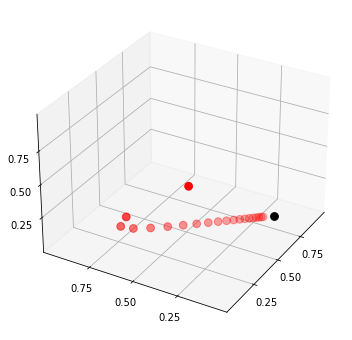

In [23]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
P = np.array(P)

ψ = (0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()

### Pageranking

Let $j$ be a typical page and $r_j$ be its ranking, we set

$$r_j \sum_{i \in L_j} \frac{r_i}{l_i}$$

where 

* $l_i$ is the total number of outbound links from $i$
* $L_j$ is the set of all pages $i$ such that $i$ has a link to $j$

This is a measure of the number of inbound linds, weighted by their own ranking. There is, however, another interpretation, and it brings us back to Markov chains. 

Let $P$ be the matrix given by $P(i, j) = 1\{i \to j \} / l_i$ if $i$ has a link to $j$ and zero otherwise. The matrix $P$ is a stochastic matrix provided that each page has at least one link.

Let's think of $P(i, j)$ as the probability of "moving" from page i to page j. The value $P(i, j)$ has the interpretation:

* $P(i, j) = 1/k$ if $i$ has $k$ outbound links and $j$ is one of them.
* $P(i, j) = 0$ if $i$ has no direct link to $j$

Thus, motion from page to page is that of a web surfer who moves from one page to another by randomly clicking on one of the links on that page. Here “random” means that each link is selected with equal probability.

In [26]:
import re
from operator import itemgetter

infile = 'web_graph_data.txt'
alphabet = 'abcdefghijklmnopqrstuvwxyz'

n = 14  # total number of web pages (nodes)

# create a matrix Q indicating existence of links
# Q[i, j] = 1 if there is link from i to j
# Q[i, j] = 0 otherwise

Q = np.zeros((n, n), dtype = int)
f = open(infile, 'r')
edges = f.readlines()
f.close()
for edge in edges:
    from_node, to_node = re.findall('\w', edge)
    i, j = alphabet.index(from_node), alphabet.index(to_node)
    Q[i, j] = 1
P = np.empty((n, n))
for i in range(n):
    P[i, :] = Q[i, :] / Q[i, :].sum()
mc = MarkovChain(P)

r = mc.stationary_distributions[0]
ranked_pages = {alphabet[i]: r[i] for i in range(n)}
# Print solution, sorted from highest to lowest rank
print('Rankings\n ***')
for name, rank in sorted(ranked_pages.items(), key=itemgetter(1), reverse=1):
    print(f'{name}: {rank:.4}')

Rankings
 ***
g: 0.1607
j: 0.1594
m: 0.1195
n: 0.1088
k: 0.09106
b: 0.08326
e: 0.05312
i: 0.05312
c: 0.04834
h: 0.0456
l: 0.03202
d: 0.03056
f: 0.01164
a: 0.002911


In [27]:
r

array([0.00291071, 0.08326461, 0.04834211, 0.0305625 , 0.05312053,
       0.01164286, 0.16070779, 0.04560118, 0.05312053, 0.15936158,
       0.0910629 , 0.03201785, 0.11951512, 0.10876974])

In [28]:
mc.stationary_distributions

array([[0.00291071, 0.08326461, 0.04834211, 0.0305625 , 0.05312053,
        0.01164286, 0.16070779, 0.04560118, 0.05312053, 0.15936158,
        0.0910629 , 0.03201785, 0.11951512, 0.10876974]])